<a href="https://colab.research.google.com/github/shelausadi/Thinkful-DataScienceBootcamp/blob/master/Supervised_Learning_Capstone_OkCupid_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning Capstone: Predicting Age and Relationship Status of OkCupid Users

### Author: Shela Usadi
shelausadi@gmail.com

In this project, we analyze a dataset of OkCupid users in San Francisco. These are about 60k users who had active accounts in June of 2012. The dataset was created scrapping data from public profiles. User names were removed for privacy reasons. The dataset includes users within a 25 mile radius of San Francisco who had at least one profile picture. OkCupid granted permission for the use of the data. It is available online at [this Github repository](https://github.com/rudeboybert/JSE_OkCupid).

We will use and compare different regression techniques to predict the age of users, and classification techniques to predict their relationship status. 


##Importing modules and dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
okcupid_df = pd.read_csv('https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles.csv.zip?raw=true', compression='zip')

##Exploring the data


In [0]:
okcupid_df.head(3)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available


In [0]:
okcupid_df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [0]:
okcupid_df.shape

(59946, 31)

After looking at the data, I wondered what the essay questions were. The [codebook](https://github.com/rudeboybert/JSE_OkCupid/blob/master/okcupid_codebook.txt) gave an explanation:

* essay0- "My self summary"
* essay1- "What I’m doing with my life"
* essay2- "I’m really good at"
* essay3- "The first thing people usually notice about me"
* essay4- "Favorite books, movies, show, music, and food"
* essay5- "The six things I could never do without"
* essay6- "I spend a lot of time thinking about"
* essay7- "On a typical Friday night I am"
* essay8- "The most private thing I am willing to admit"
* essay9- "You should message me if...""

For the purposes of this project, I don't think they will be useful so I will be deleting them.

In [0]:
okcupid_df = okcupid_df.drop(columns=['essay0','essay1','essay2','essay3','essay4','essay5', 'essay6','essay7','essay8', 'essay9'])

In [0]:
okcupid_df.head()

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


In [0]:
okcupid_df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status'],
      dtype='object')

Let's take a look at how many unique values each column has!

In [0]:
categorical = okcupid_df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

body_type
12
diet
18
drinks
6
drugs
3
education
32
ethnicity
217
job
21
last_online
30123
location
199
offspring
15
orientation
3
pets
15
religion
45
sex
2
sign
48
smokes
5
speaks
7647
status
5


"Speaks" refers to the combination of languages that a person uses. It has so many variations and levels that we decided to discard it. 

Here we use [pandas's profiling function](https://github.com/pandas-profiling/pandas-profiling) to get a quick exploratory overview of the data.  

In [0]:
import pandas_profiling
pandas_profiling.ProfileReport(okcupid_df)

Number of variables,21
Number of observations,59946
Total Missing (%),12.7%
Total size in memory,9.6 MiB
Average record size in memory,168.0 B
Numeric,3
Categorical,18
Boolean,0
Date,0
Text (Unique),0
Rejected,0


last_online has a 30,000+ unique values but does not add a lot to the analysis so I will drop it too. 

However, I think that the other features are interesting and that we should keep them. 


In [0]:
okcupid_df = okcupid_df.drop(columns = ['last_online'])

Now, let's see what the dataframe looks like after we make all the changes.



In [0]:
okcupid_df.head()

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


There are a lot of nan and that will be bad for the model. I tried to drop all nan but that gets rid of a lot of the data. I am going to try and replace all nan values with the mode for each category. 

In [0]:
column_mode = okcupid_df.mode()

In [0]:
mode = {'age' : 26,
  'body_type' : 'average',
  'diet' : 'mostly anything',
  'drinks' : 'socially',
  'drugs': 'never',
  'education': 'graduated from college/university',
  'ethnicity' : 'white',
  'height' : 70.0,
  'income' : -1,
  'job' : 'other',
  'location' : 'san francisco, california',
  'offspring' : 'doesn&rsquo;t have kids',
  'orientation' : 'straight',
  'pets' : 'likes dogs and likes cats',
  'religion' : 'agnosticism',
  'sex' : 'm',
  'sign' : 'gemini and it&rsquo;s fun to think about',
  'smokes' : 'no',
  'speaks' : 'english',
  'status' : 'single'}

In [0]:
okcupid_df.fillna(value=mode, inplace=True)

In [0]:
okcupid_df.head(5)

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,never,graduated from masters program,white,68.0,-1,other,"san francisco, california",doesn&rsquo;t have kids,straight,has cats,agnosticism,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,never,working on college/university,white,71.0,20000,student,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,agnosticism,m,pisces,no,"english, german (poorly)",single
4,29,athletic,mostly anything,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,"san francisco, california",doesn&rsquo;t have kids,straight,likes dogs and likes cats,agnosticism,m,aquarius,no,english,single


Let's take a look at the correlation of the features

In [0]:
numerical_df = okcupid_df[['height','income', 'age']]
categorical_df = okcupid_df[['body_type', 'diet', 'drinks', 
                            'drugs', 'education', 'job', 
                             'offspring', 'orientation',
                            'pets', 'religion', 'sex', 
                             'smokes', 'status']]
categorical_dummies = pd.get_dummies(categorical_df)

okcupid_features = pd.concat([categorical_dummies, numerical_df], axis=1, sort=False)

In [0]:
okcupid_features.corr()

,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,drugs_never,drugs_often,drugs_sometimes,education_college/university,...,religion_christianity,religion_christianity and laughing about it,religion_christianity and somewhat serious about it,religion_christianity and very serious about it,religion_christianity but not too serious about it,religion_hinduism,religion_hinduism and laughing about it,religion_hinduism and somewhat serious about it,religion_hinduism and very serious about it,religion_hinduism but not too serious about it,religion_islam,religion_islam and laughing about it,religion_islam and somewhat serious about it,religion_islam and very serious about it,religion_islam but not too serious about it,religion_judaism,religion_judaism and laughing about it,religion_judaism and somewhat serious about it,religion_judaism and very serious about it,religion_judaism but not too serious about it,religion_other,religion_other and laughing about it,religion_other and somewhat serious about it,religion_other and very serious about it,religion_other but not too serious about it,sex_f,sex_m,smokes_no,smokes_sometimes,smokes_trying to quit,smokes_when drinking,smokes_yes,status_available,status_married,status_seeing someone,status_single,status_unknown,height,income,age
body_type_a little extra,1.000000,-0.106133,-0.151246,-0.056681,-0.111099,-0.028022,-0.018011,-0.018500,-0.012329,-0.037433,-0.062546,-0.016530,0.002367,0.003113,0.009127,0.012923,0.008337,-0.003813,0.004968,-0.001984,-0.019618,-0.001667,-0.001819,-0.003712,-0.003712,-0.006425,-0.003969,-0.002292,0.000061,-0.010292,-0.001250,0.019997,0.004508,0.029613,-0.033386,-0.000605,-0.023046,0.006938,0.021851,-0.004348,...,-0.002213,0.000665,0.012112,0.014715,0.019457,-0.003267,0.000212,0.003816,0.002058,-0.005246,0.002577,-0.003499,0.000150,0.002378,0.003930,-0.009595,-0.006815,-0.004493,-0.004104,-0.007018,0.002747,0.010177,0.012361,0.005749,0.010175,-0.039319,0.039319,-0.047692,0.013367,0.038372,0.013246,0.031914,0.007605,0.010681,0.002002,-0.009731,0.003541,0.028132,0.004051,0.040405
body_type_athletic,-0.106133,1.000000,-0.349967,-0.131154,-0.257071,-0.064841,-0.041676,-0.042808,-0.028528,-0.086615,-0.144726,-0.038249,0.012125,-0.000522,-0.006714,-0.005197,0.011171,0.003372,0.014179,-0.005398,-0.009013,0.001550,0.011096,0.005932,-0.001328,0.009153,-0.010866,-0.017311,-0.011293,-0.016591,-0.016914,-0.010367,-0.037231,-0.017447,0.046868,-0.012757,0.041278,-0.019757,-0.037334,-0.000338,...,0.026227,0.001844,-0.007057,-0.002128,0.011373,-0.002082,-0.004142,0.003459,-0.004830,-0.001881,0.005242,-0.005530,0.001450,0.006939,0.009927,-0.001945,-0.010788,-0.010374,-0.007306,0.003179,0.006366,-0.005400,-0.008459,-0.004952,-0.008810,-0.209141,0.209141,0.061430,-0.020622,-0.031830,-0.018225,-0.049809,-0.023113,-0.019361,-0.048277,0.055508,-0.003154,0.175161,0.027333,-0.015249
body_type_average,-0.151246,-0.349967,1.000000,-0.186903,-0.366343,-0.092402,-0.059391,-0.061004,-0.040654,-0.123432,-0.206243,-0.054507,-0.014142,-0.001726,-0.006954,0.055893,-0.007476,-0.008061,-0.019860,-0.012990,-0.040323,-0.002936,-0.024390,-0.008152,-0.004066,-0.020221,0.001800,0.000835,0.002786,0.004740,-0.013150,-0.000179,0.021778,0.002569,-0.012234,-0.006308,0.005826,-0.005771,-0.004536,0.008773,...,-0.000443,-0.003206,0.007611,0.000964,-0.004300,-0.002186,0.003083,0.004213,-0.008477,0.000266,0.002537,-0.000703,-0.0

In [0]:
okcupid_features.columns

Index(['body_type_a little extra', 'body_type_athletic', 'body_type_average',
       'body_type_curvy', 'body_type_fit', 'body_type_full figured',
       'body_type_jacked', 'body_type_overweight', 'body_type_rather not say',
       'body_type_skinny',
       ...
       'smokes_when drinking', 'smokes_yes', 'status_available',
       'status_married', 'status_seeing someone', 'status_single',
       'status_unknown', 'height', 'income', 'age'],
      dtype='object', length=185)

Since there are 185 features, visualizing the correlation using a heatmap would not be very helpful. Instead, let's take a look at which features has the highest correlation with age and relationship status.

In [0]:
okcupid_features.corr()['age'].sort_values(ascending=False).head(10)

age                                                 1.000000
offspring_has kids                                  0.304091
offspring_has a kid                                 0.201297
education_graduated from masters program            0.181391
offspring_has kids, but doesn&rsquo;t want more     0.159777
smokes_no                                           0.145536
job_retired                                         0.120106
offspring_has a kid, but doesn&rsquo;t want more    0.117713
drugs_never                                         0.111987
job_executive / management                          0.100993
Name: age, dtype: float64

In [0]:
okcupid_features.corr()['status_available'].sort_values(ascending=False).head(10)

status_available                                                 1.000000
orientation_bisexual                                             0.168472
drugs_sometimes                                                  0.090999
offspring_doesn&rsquo;t want kids                                0.079332
education_dropped out of college/university                      0.048916
religion_atheism and very serious about it                       0.043826
religion_atheism and laughing about it                           0.040205
pets_likes dogs and has cats                                     0.040090
religion_atheism and somewhat serious about it                   0.039556
offspring_doesn&rsquo;t have kids, and doesn&rsquo;t want any    0.030905
Name: status_available, dtype: float64

In [0]:
okcupid_features.corr()['status_married'].sort_values(ascending=False).head(10)

status_married                                    1.000000
orientation_bisexual                              0.050645
offspring_has kids                                0.035017
age                                               0.031850
pets_has dogs and has cats                        0.029100
pets_likes dogs and has cats                      0.025828
offspring_has a kid                               0.024377
body_type_overweight                              0.023609
religion_atheism and somewhat serious about it    0.022874
pets_dislikes dogs and has cats                   0.022673
Name: status_married, dtype: float64

In [0]:
okcupid_features.corr()['status_seeing someone'].sort_values(ascending=False).head(10)

status_seeing someone                             1.000000
orientation_bisexual                              0.085343
offspring_doesn&rsquo;t want kids                 0.049340
drugs_sometimes                                   0.043340
pets_likes dogs and has cats                      0.040186
job_computer / hardware / software                0.034980
religion_atheism and somewhat serious about it    0.033160
pets_likes cats                                   0.032859
sex_f                                             0.032208
orientation_gay                                   0.028707
Name: status_seeing someone, dtype: float64

In [0]:
okcupid_features.corr()['status_single'].sort_values(ascending=False).head(10)

status_single                                        1.000000
orientation_straight                                 0.143101
drugs_never                                          0.098264
religion_agnosticism                                 0.060808
body_type_athletic                                   0.055508
drinks_socially                                      0.050818
offspring_doesn&rsquo;t have kids, but wants them    0.042242
pets_likes dogs                                      0.041140
job_banking / financial / real estate                0.038044
job_sales / marketing / biz dev                      0.037732
Name: status_single, dtype: float64

Now let's explore the data some more

In [0]:
body_type_distribution = okcupid_df.groupby('body_type')['body_type'].count().sort_values(ascending=True)

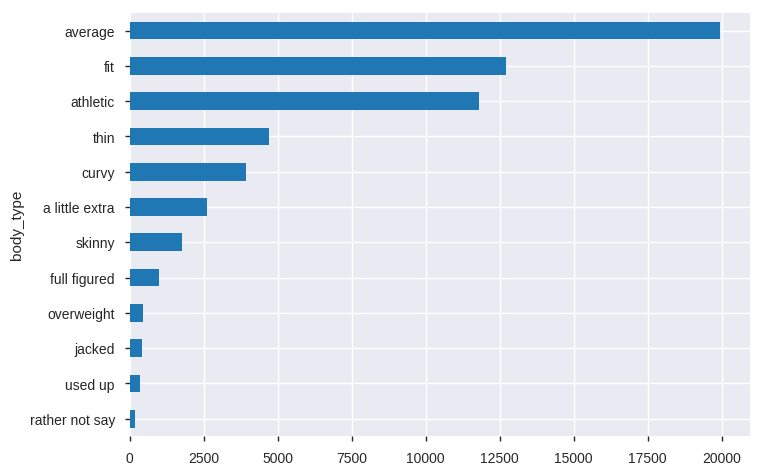

In [0]:
body_type_distribution.plot.barh();

In [0]:
status_distribution = okcupid_df.groupby('status')['status'].count().sort_values(ascending=True)

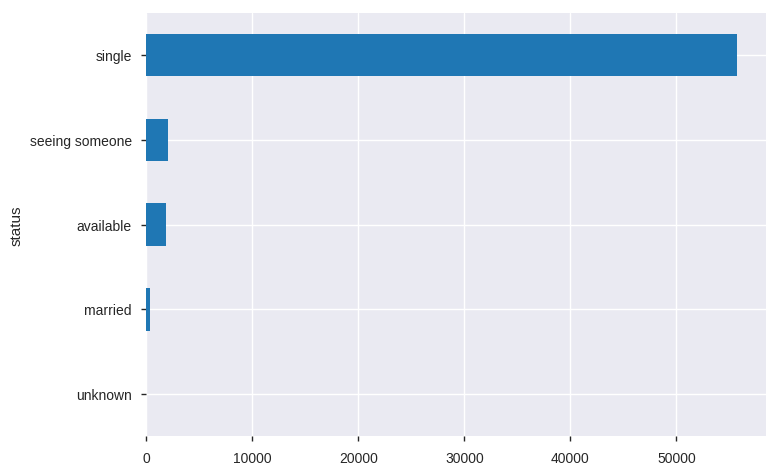

In [0]:
status_distribution.plot.barh();

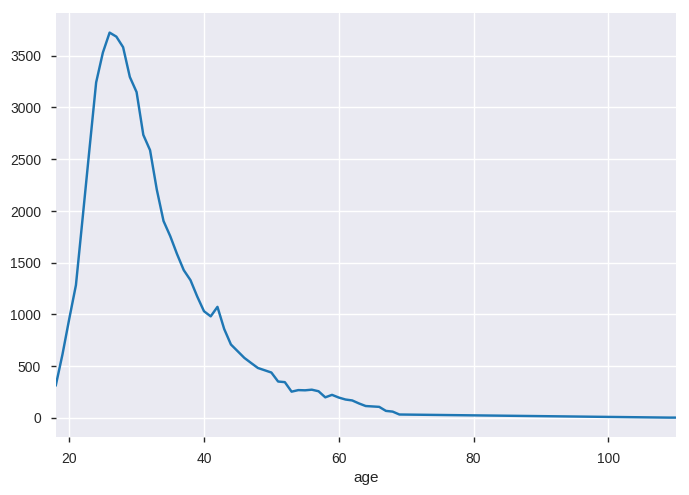

In [0]:
age_distribution = okcupid_df.groupby('age')['age'].count()
age_distribution.plot();

##Predicting User's Age Using Regression Models
###KNN Regression 

In [0]:
numerical_reg_df = okcupid_df[['height','income']]
categorical_reg_df = okcupid_df[['body_type', 'diet', 'drinks', 
                            'drugs', 'education', 'job', 
                             'offspring', 'orientation',
                            'pets', 'religion', 'sex', 
                             'smokes', 'status']]
X_reg_dummies = pd.get_dummies(categorical_reg_df)
X_reg = pd.concat([X_reg_dummies, numerical_reg_df], axis=1, sort=False)

In [0]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score


knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = X_reg
Y = okcupid_df.age
knn.fit(X, Y)

knn_cvs = cross_val_score(knn, X, Y, cv=10)

In [0]:
knn_cvs

array([0.20275311, 0.20841679, 0.21768125, 0.17872142, 0.18091249,
       0.18587137, 0.18882662, 0.2077037 , 0.2265196 , 0.20539886])

In [0]:
knn_cvs.mean()

0.20028052094334262

###OSL Regression 

In [0]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
X = X_reg
Y = okcupid_df.age
regr.fit(X, Y)

regr_cvs = cross_val_score(regr, X, Y, cv=10)
regr_cvs

array([0.37649174, 0.3807647 , 0.38751391, 0.37188218, 0.36758637,
       0.36277996, 0.36485258, 0.38107895, 0.39682077, 0.40418353])

In [0]:
regr_cvs.mean()

0.3793954691217244

## Predicting User's Relationship Status Using Classification Models

### Random Forest


In [0]:
numerical_clas_df = okcupid_df[['height','income', 'age']]
categorical_clas_df = okcupid_df[['body_type', 'diet', 'drinks', 
                            'drugs', 'education', 'job', 
                             'offspring', 'orientation',
                            'pets', 'religion', 'sex', 
                             'smokes']]
X_clas_dummies = pd.get_dummies(categorical_clas_df)
X_clas = pd.concat([X_clas_dummies, numerical_clas_df], axis=1, sort=False)

In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score 

In [0]:
rfc = ensemble.RandomForestClassifier(random_state = 10, 
                                      n_jobs=-1,  
                                      n_estimators=5)
X = X_clas
Y = okcupid_df['status']

rfc_cvs = cross_val_score(rfc, X, Y, cv=10)
rfc_cvs

array([0.9179453 , 0.92078052, 0.91727819, 0.92044696, 0.91859883,
       0.92042042, 0.91825158, 0.9249124 , 0.92090773, 0.92074086])

In [0]:
rfc_cvs.mean()

0.9200282792829636

###Gradient Boosting 

In [0]:
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [0]:
gbc = ensemble.GradientBoostingClassifier(n_estimators = 20,
                                          max_depth = 2,
                                          loss = 'deviance')

X = X_clas
Y = okcupid_df['status']

gbc.fit(X, Y)

gbc_cvs = cross_val_score(gbc, X, Y, cv=10)
gbc_cvs

array([0.92895264, 0.92895264, 0.92895264, 0.92895264, 0.92910759,
       0.9292626 , 0.9292626 , 0.92925079, 0.92925079, 0.92925079])

In [0]:
gbc_cvs.mean()

0.9291195699650882